In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from scipy.io import loadmat
from scipy.special import logit, expit
from load_data import extract_data
from preprocessing import normalize, normalize_jointly, t_com, realign_using_tcom, bVar, padding_data, R_ave_shift
from create_and_train_RNN import RandomNetwork
from utilities import basic_selectivity, plotting, CD_analysis, calc_edges, generate_train_test, norm_factor
from sklearn.decomposition import PCA
from scipy.linalg import subspace_angles

## Load recorded data

In particular, load session 16 which contains the simultaneous recodings from 87 neurons (largest network available).

In [2]:
recording_index = 16
print(f"SESSION NUMBER {recording_index}")
psth_right_c, psth_left_c, start_sample, start_delay, start_cue, selectivity, n_type = extract_data(recording_index)

# Compute averages across trials
target_R = np.nanmean(psth_right_c, axis=1)
target_L = np.nanmean(psth_left_c, axis=1)  

# Normalize both target_R and target_L jointly
target_R, target_L = normalize_jointly(target_R, target_L)
t_coms_R = t_com(target_R)
t_coms_L = t_com(target_L)
sorted_indices_R = np.argsort(t_coms_R)
sorted_indices_L = np.argsort(t_coms_L)
R_true_sorted_R = target_R[sorted_indices_R]
R_true_sorted_L = target_L[sorted_indices_L]
t_coms_sorted_R = t_coms_R[sorted_indices_R]
t_coms_sorted_L = t_coms_L[sorted_indices_L]
R_aligned_R = realign_using_tcom(target_R, t_coms_R)
R_aligned_L = realign_using_tcom(target_L, t_coms_L)

# b_var from data (see Rajan et al., 2016)
R_ave_R = np.mean(R_aligned_R, axis=0)
R_ave_L = np.mean(R_aligned_L, axis=0)
b_var_R = bVar(target_R, R_ave_R, t_coms_R)
b_var_L = bVar(target_L, R_ave_L, t_coms_L)
print(f"bvar_R={np.round(b_var_R*100,2)}%, bvar_L={np.round(b_var_L*100,2)}%")
N_units = target_R.shape[0]
idx_all = [i for i in range(N_units)]

# create targets
t_list_double = [target_R, target_L]
t_list_cut = [target_R[:,start_sample:]]
t_list_double_cut = [target_R[:,start_sample:], target_L[:,start_sample:]]

SESSION NUMBER 16


100%|██████████| 87/87 [01:30<00:00,  1.04s/it]
C:\Users\Elena Zoppellari\Desktop\PHYSICS OF DATA\V Physical Models of Living Systems\project\PROJECT\matrix_analysis.py:124: RuntimeWarning: Mean of empty slice
  mean_act_delay[:, trial] = np.nanmean(psth[:, trial, int(start_delay_idx[trial]):int(start_cue_idx[trial])], axis=1)


bvar_R=14.55%, bvar_L=12.07%


bvar_R=14.55%, bvar_L=12.07% indicates that the activity of neurons during R and L trials is compatible only slightly with a moving bell-shaped activity. (see Rajan et al., 2016)

## Train the network

Define time indices

In [3]:
start_cue_idx_left_c = np.ones(201)*(start_cue - 1000)
start_cue_left_c = np.ones(201)*np.linspace(0, 6, 6000)[start_cue]
times_left_c = np.ones((201, 6000))[:,1000:(start_cue+250)]*np.linspace(0, 6, 6000)[1000:(start_cue+250)] 
start_sample_right_c = np.ones(201)*np.linspace(0, 6, 6000)[start_sample]
start_delay_right_c = np.ones(201)*np.linspace(0, 6, 6000)[start_delay]
start_cue_right_c = np.ones(201)*np.linspace(0, 6, 6000)[start_cue]
times_right_c = np.ones((201, 6000))[:,1000:(start_cue+250)]*np.linspace(0, 6, 6000)[1000:(start_cue+250)]

### Target = original data

We create 10 different realizations, the convergence criteria is pvar. Some of the converging trajectories might be able to memorize different behaviour in delay epoch for left and right trials. Therefore, we keep only the trials that show enought selectivity in delay epoch.

In [11]:
p = 1
# remove from the target extra tails of activity
t_list_double_ideal = [target_R[:,1000:(start_cue+250)], target_L[:,1000:(start_cue+250)]]
start_ideal = (start_cue - 600) - 1000 
end_ideal = start_cue - 1000
# create different realizations training the random network several times
n_gen = 10
J_matrix_p_ideal = []
J_matrix_p_random_ideal = []
r_p_ideal = []
r_p_random_ideal = []
noise_vector_ideal = []
# selectivity of recorded data
baseline = basic_selectivity(target_L.T, target_R.T, (start_cue-600), start_cue)
for i in range(n_gen):
    FCnetwork_DPA_RL = RandomNetwork(N = N_units, n_tasks = 2, start_sample=start_sample, start_delay=start_delay, start_cue=start_cue, cut=False, J=None, frozen_input=None)
    r_history_random, pvar_history_random, J_random, J_random = FCnetwork_DPA_RL.train(target = t_list_double_ideal, n_iters=1, idx = [idx_all, idx_all], p=p, test=True)
    r_history_DPA_RL, pvar_history_DPA_RL, J_DPA_RL, J_random, noise = FCnetwork_DPA_RL.train(target = t_list_double_ideal, n_iters=50, idx = [idx_all, idx_all], p=p, test=False, perturbate=False, amp_noise=None)
    select = sum([i==j for (i,j) in zip(basic_selectivity(r_history_DPA_RL[1], r_history_DPA_RL[0], (end_ideal-600), end_ideal), baseline)])/87
    # if the network predictions conserve the selectivity of recorded data, save J, r and frozen_noise
    if select > 0.5:
        print("selectivity:", select)
        J_matrix_p_ideal.append(J_DPA_RL)
        J_matrix_p_random_ideal.append(J_random)
        r_p_ideal.append(r_history_DPA_RL)
        r_p_random_ideal.append(r_history_random)
        noise_vector_ideal.append(noise)

 48%|████▊     | 24/50 [01:35<01:43,  3.99s/it]

convergence reached at iter=24
iter 24 p_var=[87.83, 90.36]% and avg_error=[2.0, 2.05]
selectivity: 0.9080459770114943



100%|██████████| 50/50 [03:15<00:00,  3.91s/it]

iter 49 p_var=[84.9, 86.91]% and avg_error=[2.01, 2.03]



100%|██████████| 50/50 [03:21<00:00,  4.03s/it]

iter 49 p_var=[-38.89, 87.51]% and avg_error=[2.64, 2.04]



 96%|█████████▌| 48/50 [03:08<00:07,  3.92s/it]

convergence reached at iter=48
iter 48 p_var=[85.01, 86.83]% and avg_error=[2.02, 2.04]



100%|██████████| 50/50 [03:10<00:00,  3.80s/it]

iter 49 p_var=[66.92, 83.15]% and avg_error=[2.05, 2.03]



100%|██████████| 50/50 [03:08<00:00,  3.78s/it]

iter 49 p_var=[67.46, 87.12]% and avg_error=[2.15, 2.03]



 50%|█████     | 25/50 [01:38<01:38,  3.96s/it]

convergence reached at iter=25
iter 25 p_var=[85.17, 86.19]% and avg_error=[2.02, 2.03]



 78%|███████▊  | 39/50 [02:43<00:46,  4.19s/it]

convergence reached at iter=39
iter 39 p_var=[86.31, 88.54]% and avg_error=[1.99, 2.05]
selectivity: 0.7126436781609196



 34%|███▍      | 17/50 [01:13<02:22,  4.33s/it]

convergence reached at iter=17
iter 17 p_var=[87.89, 89.32]% and avg_error=[1.99, 2.05]
selectivity: 0.7701149425287356



 84%|████████▍ | 42/50 [02:47<00:31,  4.00s/it]

convergence reached at iter=42
iter 42 p_var=[85.22, 86.42]% and avg_error=[2.01, 2.03]


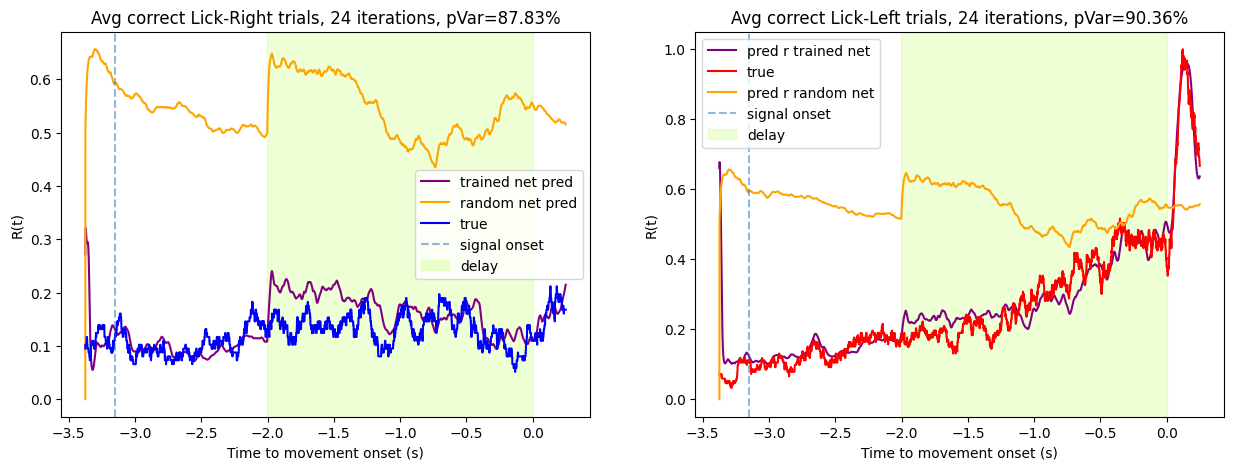

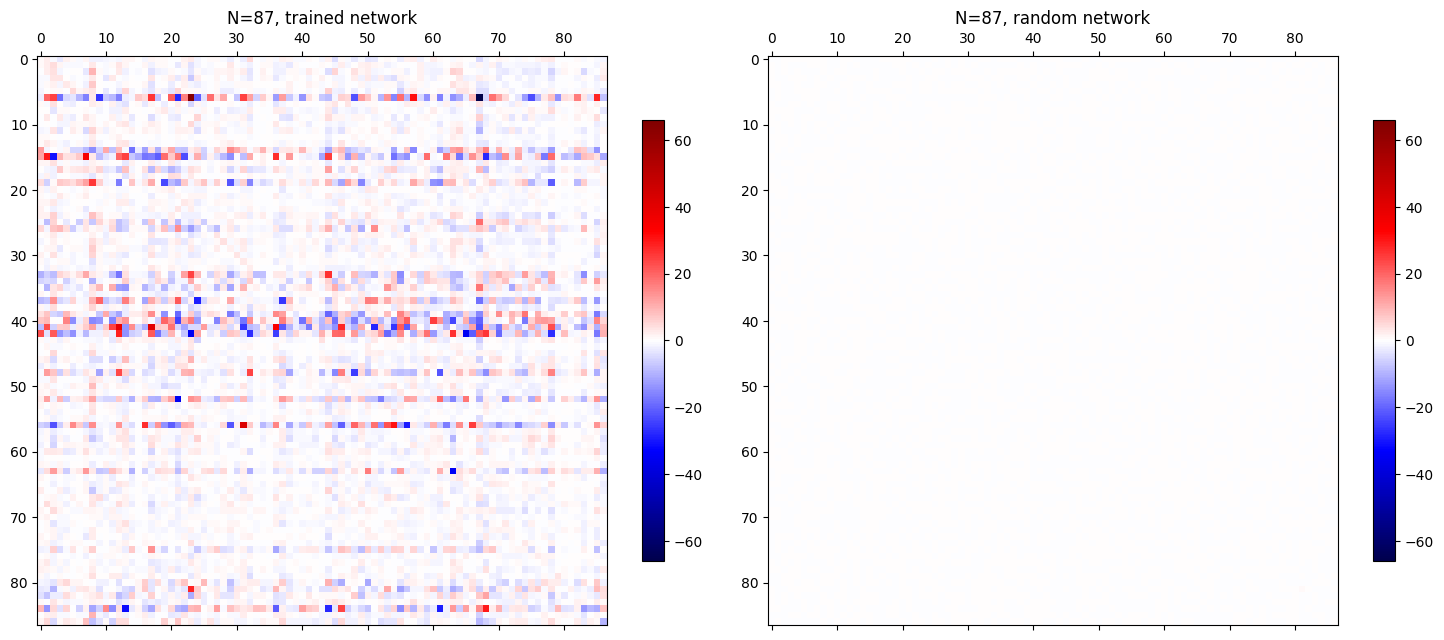

In [16]:
plotting([0], 3, t_list_double_ideal, r_p_ideal, r_p_random_ideal, J_matrix_p_ideal, J_matrix_p_random_ideal, 24, [87.83, 90.36], start_cue, start_cue_right_c, start_sample_right_c, start_delay_right_c)

### Suppress activity of L/R selective neurons during R/L trials 

Create targets similar to those used by Rajan et al., 2016

In [13]:
p = 1
target_R_mod = np.zeros(target_R.shape)
target_L_mod = np.zeros(target_L.shape)
for n in range(target_R.shape[0]):
    if selectivity[n] == "right":
        target_R_mod[n] = target_R[n]
        target_L_mod[n] = np.zeros(target_L[n].shape)
    elif selectivity[n] == "left":
        target_L_mod[n] = target_L[n]
        target_R_mod[n] = np.zeros(target_R[n].shape)
    else:
        target_L_mod[n] = target_L[n]
        target_R_mod[n] = target_R[n]
t_list_double_cut_mod = [target_R_mod[:,1000:(start_cue+250)], target_L_mod[:,1000:(start_cue+250)]]
J_matrix_p_mod = []
J_matrix_p_random_mod = []
r_p_mod = []
r_p_random_mod = []
noise_vector_mod = []
baseline_mod = basic_selectivity(target_L_mod.T, target_R_mod.T, (start_cue-600), start_cue)
for i in range(n_gen):
    FCnetwork_DPA_RL = RandomNetwork(N = N_units, n_tasks = 2, start_sample=start_sample, start_delay=start_delay, start_cue=start_cue, cut=False, J=None, frozen_input=None)
    r_history_random, pvar_history_random, J_random, J_random = FCnetwork_DPA_RL.train(target = t_list_double_cut_mod, n_iters=1, idx = [idx_all, idx_all], p=p, test=True)
    r_history_DPA_RL, pvar_history_DPA_RL, J_DPA_RL, J_random, noise = FCnetwork_DPA_RL.train(target = t_list_double_cut_mod, n_iters=50, idx = [idx_all, idx_all], p=p, test=False, perturbate=False, amp_noise=None)
    select = sum([i==j for (i,j) in zip(basic_selectivity(r_history_DPA_RL[1], r_history_DPA_RL[0], (end_ideal-600), end_ideal), baseline_mod)])/87
    if select > 0.5:
        print("selectivity:", select)
        J_matrix_p_mod.append(J_DPA_RL)
        J_matrix_p_random_mod.append(J_random)
        r_p_mod.append(r_history_DPA_RL)
        r_p_random_mod.append(r_history_random)
        noise_vector_mod.append(noise)

 48%|████▊     | 24/50 [01:47<01:56,  4.48s/it]

convergence reached at iter=24
iter 24 p_var=[85.04, 93.44]% and avg_error=[4.25, 4.26]
selectivity: 0.8505747126436781



100%|██████████| 50/50 [03:19<00:00,  3.98s/it]

iter 49 p_var=[-52.8, 93.48]% and avg_error=[4.4, 4.29]



100%|██████████| 50/50 [03:24<00:00,  4.10s/it]

iter 49 p_var=[82.14, 49.05]% and avg_error=[4.25, 4.27]



 12%|█▏        | 6/50 [00:28<03:27,  4.73s/it]

convergence reached at iter=6
iter 6 p_var=[91.54, 92.21]% and avg_error=[4.25, 4.29]
selectivity: 0.9540229885057471



100%|██████████| 50/50 [03:29<00:00,  4.18s/it]

iter 49 p_var=[75.68, 77.5]% and avg_error=[4.24, 4.27]



 16%|█▌        | 8/50 [00:38<03:20,  4.78s/it]

convergence reached at iter=8
iter 8 p_var=[92.82, 91.34]% and avg_error=[4.26, 4.28]
selectivity: 0.9540229885057471



100%|██████████| 50/50 [03:34<00:00,  4.29s/it]

iter 49 p_var=[77.63, 81.67]% and avg_error=[4.24, 4.26]



100%|██████████| 50/50 [03:35<00:00,  4.31s/it]

iter 49 p_var=[78.3, 13.9]% and avg_error=[4.24, 4.36]



100%|██████████| 50/50 [03:36<00:00,  4.34s/it]

iter 49 p_var=[79.95, 78.33]% and avg_error=[4.24, 4.27]



100%|██████████| 50/50 [03:31<00:00,  4.22s/it]

iter 49 p_var=[82.01, 78.92]% and avg_error=[4.25, 4.26]


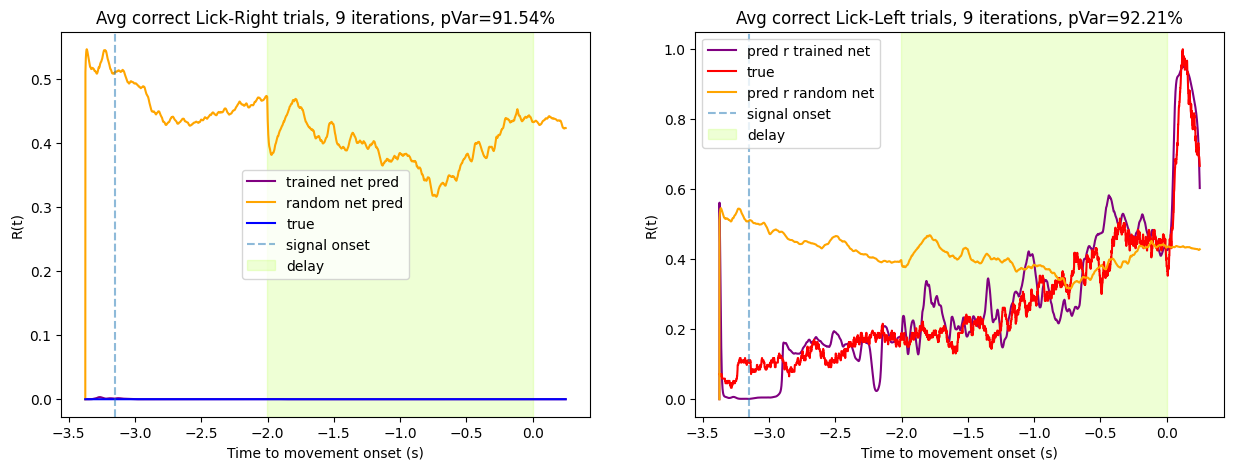

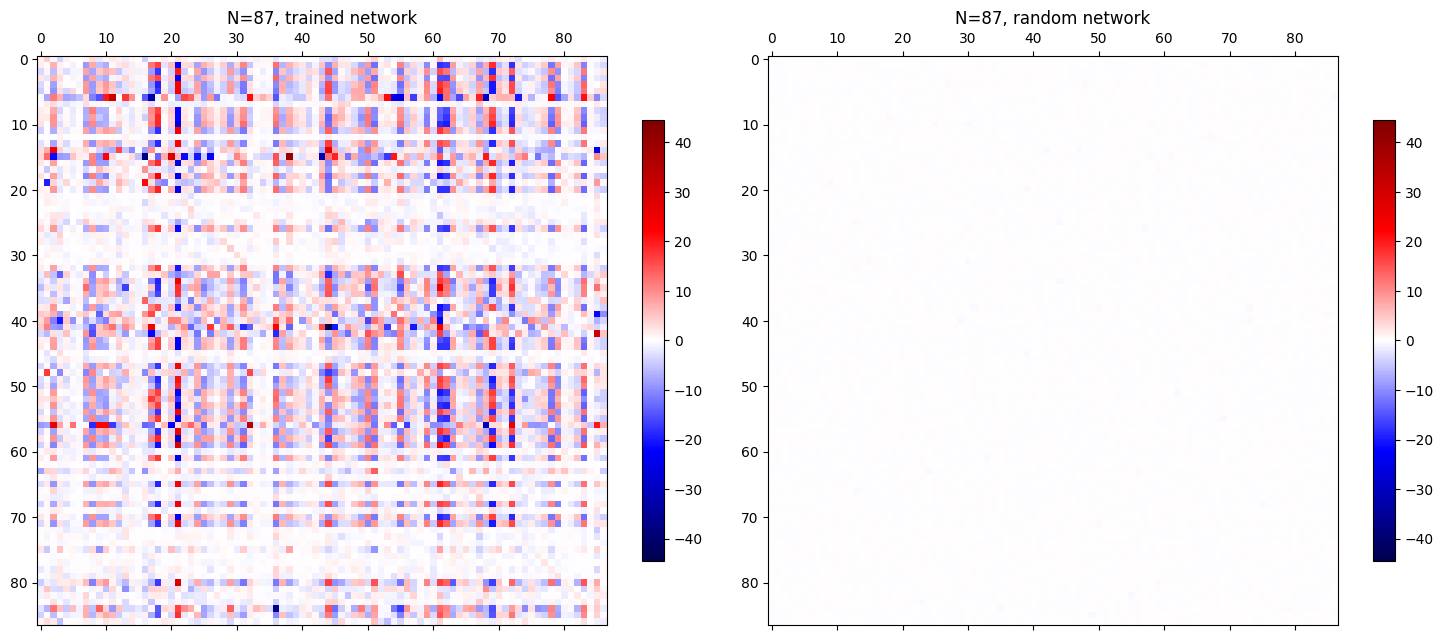

In [17]:
plotting([1], 3, t_list_double_cut_mod, r_p_mod, r_p_random_mod, J_matrix_p_mod, J_matrix_p_random_mod, 9, [91.54, 92.21], start_cue, start_cue_right_c, start_sample_right_c, start_delay_right_c)

## Analysis

assest the selectivity baselines for trained networks

In [18]:
ideal = sum([i==j for (i,j) in zip(basic_selectivity(r_p_ideal[0][1], r_p_ideal[0][0], start_ideal, end_ideal), baseline)])/87
mod = sum([i==j for (i,j) in zip(basic_selectivity(r_p_mod[1][1], r_p_mod[1][0], start_ideal, end_ideal), baseline_mod)])/87
ideal, mod

(0.9080459770114943, 0.9540229885057471)

Load the working networks and try to add noise

In [19]:
mask_right = [i == "right" for i in baseline]
mask_left = [i == "left" for i in baseline]

In [22]:
#generate J IDEAL
FCnetwork_DPA_RL = RandomNetwork(N = N_units, n_tasks = 2, start_sample=start_sample, start_delay=start_delay, start_cue=start_cue, 
                                 J=J_matrix_p_ideal[0], frozen_input=noise_vector_ideal[0])
noise = 1
print("NOISE AMPLITUDE", noise)
right_c = []
left_c = []
right_e = []
left_e = []
select = []
for i in tqdm(range(500)):
    r_history_DPA_RL, pvar_history_DPA_RL, _, _ = FCnetwork_DPA_RL.train(target = t_list_double_ideal, test=True, perturbate=True, amp_noise=noise, idx = [idx_all, idx_all], p=1)
    sel = sum([i==j for (i,j) in zip(basic_selectivity(r_history_DPA_RL[1], r_history_DPA_RL[0], start_ideal, end_ideal), baseline)])/87
    select.append(sel)
    rightsel_activity_R = r_history_DPA_RL[0][:,mask_right]
    rightsel_activity_L = r_history_DPA_RL[1][:,mask_right]
    check_R = [(act_R[end_ideal] - act_L[end_ideal])>0 for (act_R, act_L) in zip(rightsel_activity_R.T, rightsel_activity_L.T)]
    leftsel_activity_R = r_history_DPA_RL[0][:,mask_left]
    leftsel_activity_L = r_history_DPA_RL[1][:,mask_left]
    check_L = [(act_R[end_ideal] - act_L[end_ideal])<0 for (act_R, act_L) in zip(leftsel_activity_R.T, leftsel_activity_L.T)]
    if sum(check_R)/sum(mask_right) > 0.75:
        right_c.append(r_history_DPA_RL[0])
    else:
        right_e.append(r_history_DPA_RL[0])
    if sum(check_L)/sum(mask_left) > 0.75:
        left_c.append(r_history_DPA_RL[1])
    else:
        left_e.append(r_history_DPA_RL[1])


NOISE AMPLITUDE 1


100%|██████████| 500/500 [02:35<00:00,  3.21it/s]


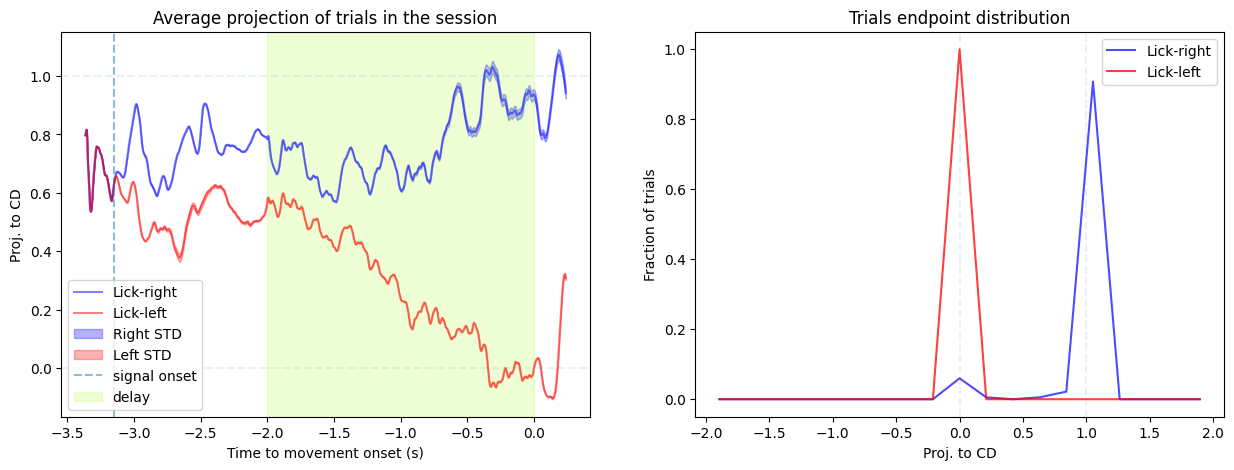

In [23]:
right_arr = np.array(right_c)
left_arr = np.array(left_c)
data_simulated_R = right_arr.transpose(2,0,1)
data_simulated_L = left_arr.transpose(2,0,1)
cd_vector, norm_right, norm_left, time_ax_r, time_ax_l, shared_start_cue_idx = CD_analysis(data_simulated_R, data_simulated_L, True, start_cue, start_sample, start_delay)

what happens when selectivity is lost, i.e., the system is not able to keep the memory of the signal?

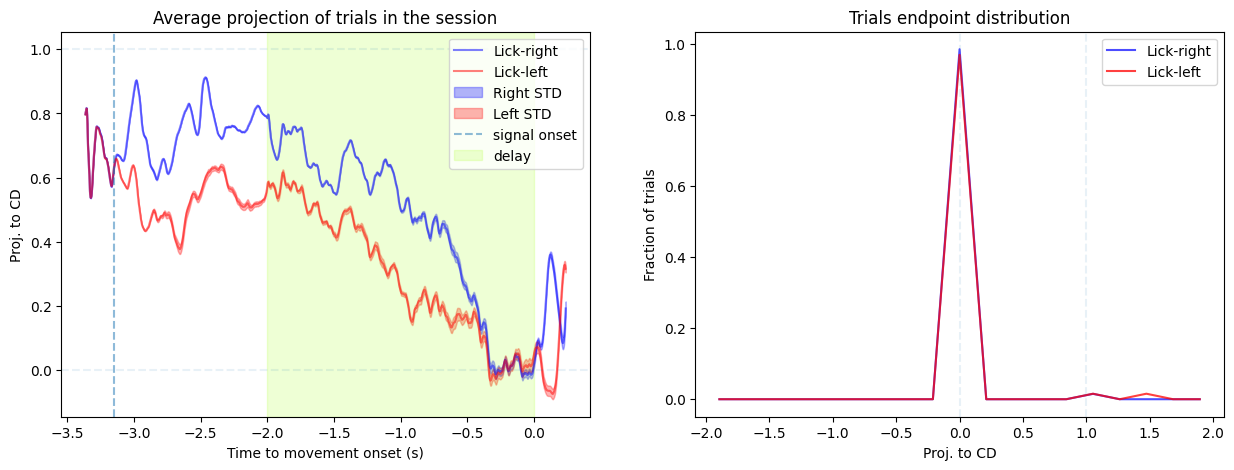

In [24]:
right_err = np.array(right_e).transpose(2,0,1)
left_err = np.array(left_e).transpose(2,0,1)
# projections 
proj_R = (np.dot(cd_vector, np.transpose(right_err, axes=(1,0,2))) - norm_left) / ( norm_right - norm_left)
proj_L = (np.dot(cd_vector, np.transpose(left_err, axes=(1,0,2))) - norm_left) / ( norm_right - norm_left)
    
# compute edges
x_R, edges_R = calc_edges(proj_R, shared_start_cue_idx)
x_L, edges_L = calc_edges(proj_L, shared_start_cue_idx)

# avg of projections between trials
mean_test_r = np.nanmean(proj_R, axis=0)
std_test_r = np.nanstd(proj_R, axis=0) / np.sqrt(np.sum(~np.isnan(proj_R).all(axis=1)))
time_ax_r = np.nanmean(times_right_c, axis=0) - np.nanmean(start_cue_right_c)
mean_test_l = np.nanmean(proj_L, axis=0)
std_test_l = np.nanstd(proj_L, axis=0) / np.sqrt(np.sum(~np.isnan(proj_L).all(axis=1)))
time_ax_l = np.nanmean(times_left_c, axis=0)  - np.nanmean(start_cue_left_c)

fig, ax = plt.subplots(1,2, figsize=(15,5))

# plot avg projection R and L
ax[0].plot(time_ax_r[10:-10], mean_test_r[10:-10], color='blue', alpha=0.5, label='Lick-right')
ax[0].axhline(1, alpha=0.1, linestyle="--")
ax[0].plot(time_ax_l[10:-10], mean_test_l[10:-10], color='red', alpha=0.5, label='Lick-left')
ax[0].axhline(0, alpha=0.1, linestyle="--")
ax[0].fill_between(time_ax_r[10:-10], 
     mean_test_r[10:-10] + std_test_r[10:-10], 
     mean_test_r[10:-10] - std_test_r[10:-10], 
     color="blue", alpha=0.3, label="Right STD")

ax[0].fill_between(time_ax_l[10:-10], 
                 mean_test_l[10:-10] + std_test_l[10:-10], 
                 mean_test_l[10:-10] - std_test_l[10:-10], 
                 color="red", alpha=0.3, label="Left STD")
ax[0].set_ylabel('Proj. to CD')
ax[0].set_xlabel('Time to movement onset (s)')
ax[0].axvline(np.nanmean(start_sample_right_c) - np.nanmean(start_cue_right_c), linestyle="--", alpha=0.5, label="signal onset")
ax[0].axvspan(np.nanmean(start_delay_right_c) - np.nanmean(start_cue_right_c), 0, alpha=0.2, color='greenyellow', label="delay")
ax[0].set_title("Average projection of trials in the session")
ax[0].legend()

ax[1].plot(x_R, edges_R, color="blue", alpha=0.7, label='Lick-right')
ax[1].plot(x_L, edges_L, color="red", alpha=0.75, label='Lick-left')
ax[1].axvline(1, linestyle="--", alpha=0.1)
ax[1].axvline(0, linestyle="--", alpha=0.1)
ax[1].set_xlabel('Proj. to CD')
ax[1].set_ylabel('Fraction of trials')
ax[1].set_title(f'Trials endpoint distribution')
ax[1].legend()

we observe that, during the delay epoch, there is a collapse of R activity towards L activity.

Let's observe that happens using the suppressed targets:

In [27]:
mask_right_mod = [i == "right" for i in baseline_mod]
mask_left_mod = [i == "left" for i in baseline_mod]

In [28]:
#generate J MOD
FCnetwork_DPA_RL = RandomNetwork(N = N_units, n_tasks = 2, start_sample=start_sample, start_delay=start_delay, start_cue=start_cue, 
                                 J=J_matrix_p_mod[1], frozen_input=noise_vector_mod[1])
noise = 1.5
print("NOISE AMPLITUDE", noise)
right_c_mod = []
left_c_mod = []
right_e_mod = []
left_e_mod = []
select_mod = []
for i in tqdm(range(500)):
    r_history_DPA_RL, pvar_history_DPA_RL, _, _ = FCnetwork_DPA_RL.train(target = t_list_double_cut_mod, test=True, perturbate=True, amp_noise=noise, idx = [idx_all, idx_all], p=1)
    sel = sum([i==j for (i,j) in zip(basic_selectivity(r_history_DPA_RL[1], r_history_DPA_RL[0], start_ideal, end_ideal), baseline_mod)])/87
    select_mod.append(sel)
    rightsel_activity_R = r_history_DPA_RL[0][:,mask_right]
    rightsel_activity_L = r_history_DPA_RL[1][:,mask_right]
    check_R = [(act_R[end_ideal] - act_L[end_ideal])>0 for (act_R, act_L) in zip(rightsel_activity_R.T, rightsel_activity_L.T)]
    leftsel_activity_R = r_history_DPA_RL[0][:,mask_left]
    leftsel_activity_L = r_history_DPA_RL[1][:,mask_left]
    check_L = [(act_R[end_ideal] - act_L[end_ideal])<0 for (act_R, act_L) in zip(leftsel_activity_R.T, leftsel_activity_L.T)]
    if sum(check_R)/sum(mask_right) > 0.75:
        right_c_mod.append(r_history_DPA_RL[0])
    else:
        right_e_mod.append(r_history_DPA_RL[0])
    if sum(check_L)/sum(mask_left) > 0.75:
        left_c_mod.append(r_history_DPA_RL[1])
    else:
        left_e_mod.append(r_history_DPA_RL[1])

NOISE AMPLITUDE 1.5


100%|██████████| 500/500 [02:44<00:00,  3.03it/s]


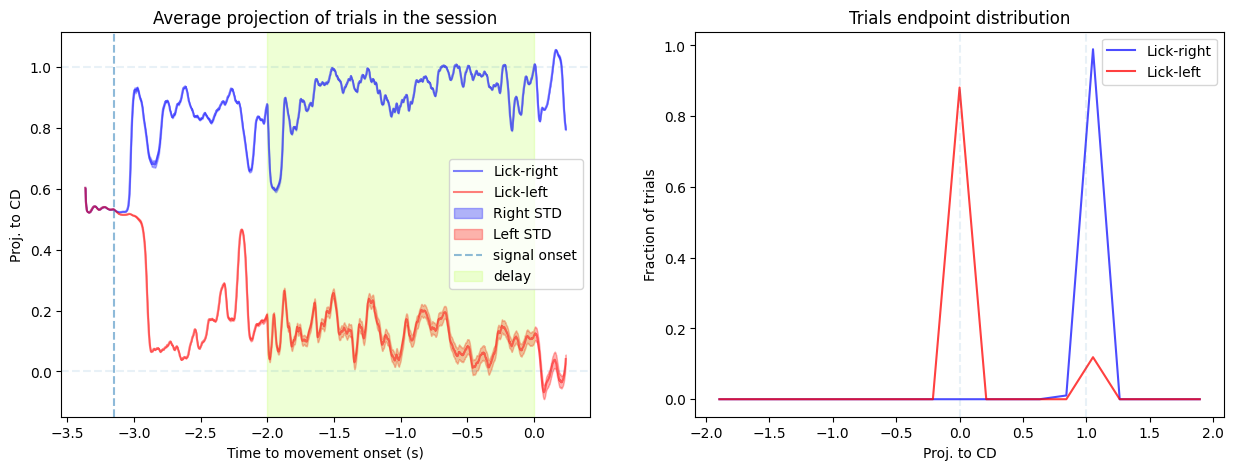

In [29]:
right_arr = np.array(right_c_mod)
left_arr = np.array(left_c_mod)
data_simulated_R = right_arr.transpose(2,0,1)
data_simulated_L = left_arr.transpose(2,0,1)
cd_vector, norm_right, norm_left, time_ax_r, time_ax_l, shared_start_cue_idx = CD_analysis(data_simulated_R, data_simulated_L, True, start_cue, start_sample, start_delay)

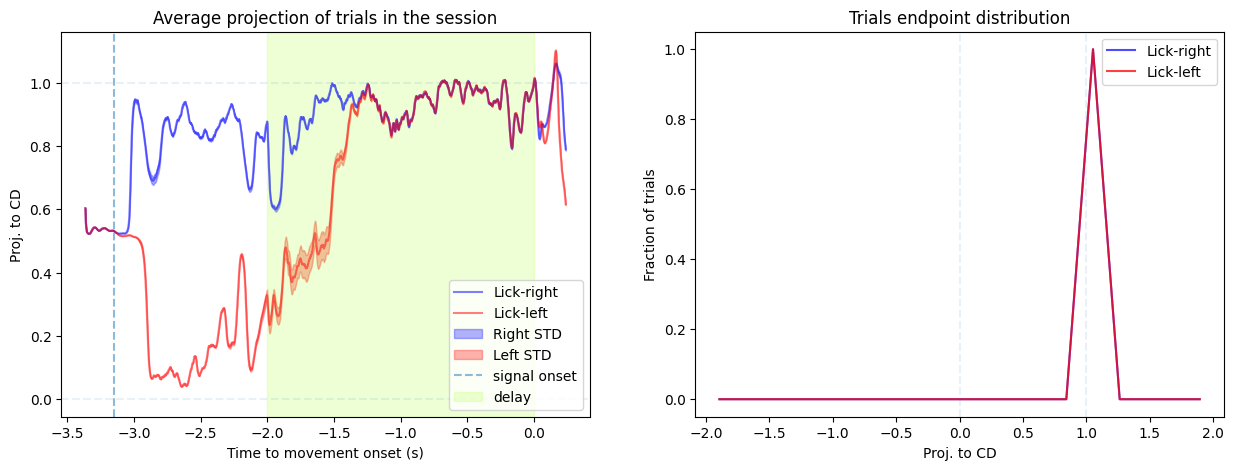

In [30]:
right_err = np.array(right_e_mod).transpose(2,0,1)
left_err = np.array(left_e_mod).transpose(2,0,1)
# projections 
proj_R = (np.dot(cd_vector, np.transpose(right_err, axes=(1,0,2))) - norm_left) / ( norm_right - norm_left)
proj_L = (np.dot(cd_vector, np.transpose(left_err, axes=(1,0,2))) - norm_left) / ( norm_right - norm_left)
    
# compute edges
x_R, edges_R = calc_edges(proj_R, shared_start_cue_idx)
x_L, edges_L = calc_edges(proj_L, shared_start_cue_idx)

# avg of projections between trials
mean_test_r = np.nanmean(proj_R, axis=0)
std_test_r = np.nanstd(proj_R, axis=0) / np.sqrt(np.sum(~np.isnan(proj_R).all(axis=1)))
time_ax_r = np.nanmean(times_right_c, axis=0) - np.nanmean(start_cue_right_c)
mean_test_l = np.nanmean(proj_L, axis=0)
std_test_l = np.nanstd(proj_L, axis=0) / np.sqrt(np.sum(~np.isnan(proj_L).all(axis=1)))
time_ax_l = np.nanmean(times_left_c, axis=0)  - np.nanmean(start_cue_left_c)

fig, ax = plt.subplots(1,2, figsize=(15,5))

# plot avg projection R and L
ax[0].plot(time_ax_r[10:-10], mean_test_r[10:-10], color='blue', alpha=0.5, label='Lick-right')
ax[0].axhline(1, alpha=0.1, linestyle="--")
ax[0].plot(time_ax_l[10:-10], mean_test_l[10:-10], color='red', alpha=0.5, label='Lick-left')
ax[0].axhline(0, alpha=0.1, linestyle="--")
ax[0].fill_between(time_ax_r[10:-10], 
     mean_test_r[10:-10] + std_test_r[10:-10], 
     mean_test_r[10:-10] - std_test_r[10:-10], 
     color="blue", alpha=0.3, label="Right STD")

ax[0].fill_between(time_ax_l[10:-10], 
                 mean_test_l[10:-10] + std_test_l[10:-10], 
                 mean_test_l[10:-10] - std_test_l[10:-10], 
                 color="red", alpha=0.3, label="Left STD")
ax[0].set_ylabel('Proj. to CD')
ax[0].set_xlabel('Time to movement onset (s)')
ax[0].axvline(np.nanmean(start_sample_right_c) - np.nanmean(start_cue_right_c), linestyle="--", alpha=0.5, label="signal onset")
ax[0].axvspan(np.nanmean(start_delay_right_c) - np.nanmean(start_cue_right_c), 0, alpha=0.2, color='greenyellow', label="delay")
ax[0].set_title("Average projection of trials in the session")
ax[0].legend()

ax[1].plot(x_R, edges_R, color="blue", alpha=0.7, label='Lick-right')
ax[1].plot(x_L, edges_L, color="red", alpha=0.75, label='Lick-left')
ax[1].axvline(1, linestyle="--", alpha=0.1)
ax[1].axvline(0, linestyle="--", alpha=0.1)
ax[1].set_xlabel('Proj. to CD')
ax[1].set_ylabel('Fraction of trials')
ax[1].set_title(f'Trials endpoint distribution')
ax[1].legend()

Here we observe the collapse of left activity into right activity during the delay epoch.